# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [196]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Are squirrels who climb more often more likely to approach humans? (linear regression?)
#Which location has squirrels that are most likely to approach humans? (clustering , N,S,E,W)

data = pd.read_csv("2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250418.csv")
print("Hello World!")

# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Now you should be able to access columns like this:
print(data.columns)  # Check to confirm exact names


Hello World!
Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


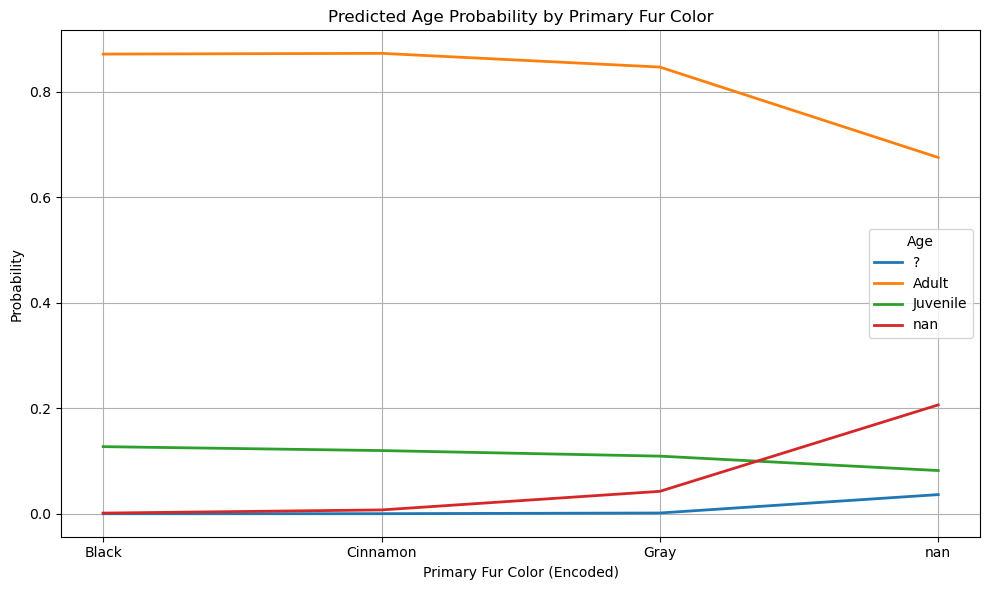

In [197]:
##Does elevation impact the secondary fur color of squirrels? (Logistic regression) (predict squirle 2nd hair color)
import pandas as pd


# Encode Primary Fur Color to integers
fur_le = LabelEncoder()
data['Fur_Color_Label'] = fur_le.fit_transform(data['Primary Fur Color'])

age_le = LabelEncoder()
data['Age_Label'] = age_le.fit_transform(data['Age'])

x = data[['Fur_Color_Label']].values
y = data[['Age_Label']].values

# Standardize
scaler = StandardScaler().fit(x)
x = scaler.transform(x)

# Train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y)

# Logistic Regression
model = LogisticRegression().fit(x_train, y_train)

# Evaluate
y_pred = model.predict(x_test)
#print(classification_report(y_test, y_pred, target_names=age_le.classes_, zero_division=0))

x_range = np.arange(data['Fur_Color_Label'].min(), data['Fur_Color_Label'].max() + 1).reshape(-1, 1)
x_range_scaled = scaler.transform(x_range) #standardize
probs = model.predict_proba(x_range_scaled) #add a probability for the age (based on fur color)

plt.figure(figsize=(10, 6))
for i, age in enumerate(age_le.classes_): #loop through the ages (Adult vs Juvenile)
    plt.plot(x_range, probs[:, i], label=age, linewidth=2)

plt.title("Predicted Age Probability by Primary Fur Color")
plt.xlabel("Primary Fur Color (Encoded)")
plt.ylabel("Probability")

# Add tick labels using fur color names
plt.xticks(x_range.flatten(), fur_le.inverse_transform(x_range.flatten()))
plt.legend(title='Age')
plt.grid(True)
plt.tight_layout()
plt.show()


Foraging_Int
0    1588
1    1435
Name: count, dtype: int64


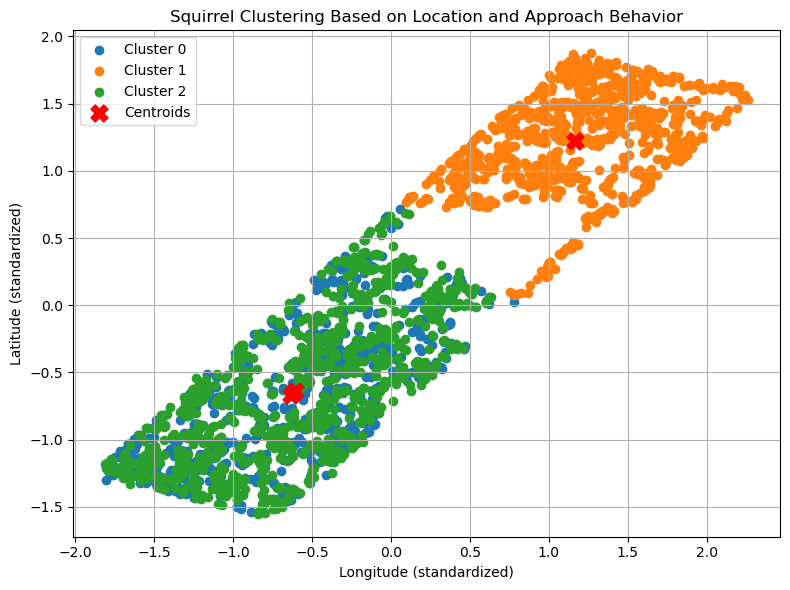

In [198]:
# Filter for squirrels with location and approach info
data = data.dropna(subset=['Foraging', 'X', 'Y'])
#data = data[data['Foraging'] != 0] #limit approaches to only approaching squirrels


# Features: latitude (X), longitude (Y)
data['Foraging_Int'] = data['Foraging'].astype(int)
features = data[['X', 'Y', 'Foraging_Int']]

print(features['Foraging_Int'].value_counts())

# Standardize features
x_std = StandardScaler().fit_transform(features)

# Set number of clusters
k = 3 #can change for different results
km = KMeans(n_clusters=k, random_state=42).fit(x_std)

# Get centroids and labels
centroids = km.cluster_centers_
labels = km.labels_

# Plot
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster = x_std[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=150, c='red', label='Centroids')

# Labels and formatting
plt.xlabel("Longitude (standardized)")
plt.ylabel("Latitude (standardized)")
plt.title("Squirrel Clustering Based on Location and Approach Behavior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


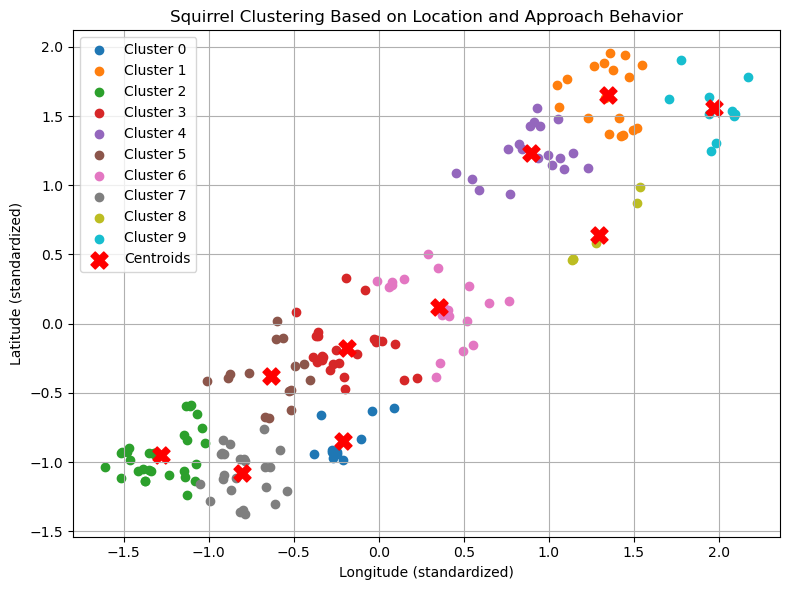

In [199]:
#Location

center_lat = 40.783875
center_lon = -73.9690349

#gets the compass direction for latitude and longitude
def get_direction(row):
    ns = 'North' if row['Y'] > center_lat else 'South'
    ew = 'West' if row['X'] > center_lon else 'East'
    return f"{ns}-{ew}"


#data['Direction'] = data.apply(get_direction, axis=1) harder to implement


# Filter for squirrels with location and approach info
data = data.dropna(subset=['Approaches', 'X', 'Y'])
data = data[data['Approaches'] != 0] #limit approaches to only approaching squirrels

# Features: latitude (X), longitude (Y)
data['Approach_Int'] = data['Approaches'].astype(int)

features = data[['X', 'Y', 'Approach_Int']]


# Standardize features
x_std = StandardScaler().fit_transform(features)

# Set number of clusters
k = 10 #can change for different results
km = KMeans(n_clusters=k, random_state=42).fit(x_std)

# Get centroids and labels
centroids = km.cluster_centers_
labels = km.labels_

# Plot
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster = x_std[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=150, c='red', label='Centroids')

# Labels and formatting
plt.xlabel("Longitude (standardized)")
plt.ylabel("Latitude (standardized)")
plt.title("Squirrel Clustering Based on Location and Approach Behavior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


